In [1]:
import csv
import cv2
import numpy as np
import sklearn

In [2]:
#read csv data file
lines = []

with open('./data/driving_log.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        lines.append(row)
    lines = lines[1:]

In [3]:
#store the left, right and center images in separate lists

centerImages = []
leftImages = []
rightImages = []
measurements = []

for line in lines:
    centerPath = line[0]
    leftPath = line[1]
    rightPath = line[2]
    fileNameCenter = centerPath.split('/')[-1]
    fileNameLeft = leftPath.split('/')[-1]
    fileNameRight = leftPath.split('/')[-1]
    centerImages.append('./data/IMG/'+fileNameCenter)
    leftImages.append('./data/IMG/'+fileNameLeft)
    rightImages.append('./data/IMG/'+fileNameRight)
    measurements.append(float (line[3]))

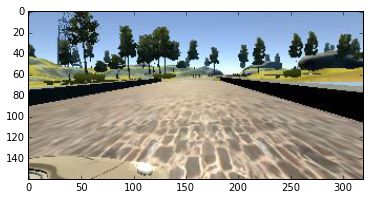

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

x = mpimg.imread(leftImages[0])
y = cv2.flip(x,1)
plt.imshow(y)  

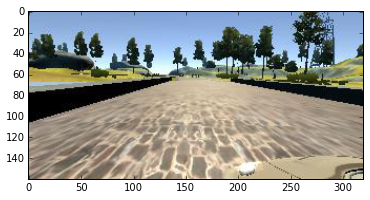

In [12]:
plt.imshow(x)  

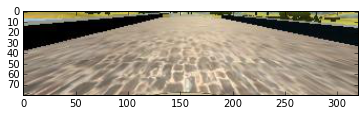

In [9]:
cropped = x[60:140, ]
# x = mpimg.imread(centerImages[0])
plt.imshow(cropped)  

In [13]:
#function to combine the left, center, right lists with correction attached to left and right steering angle measure
def clrCombined(center, left, right, measurement, correction):
    imagePaths = []
    imagePaths.extend(center)
    imagePaths.extend(left)
    imagePaths.extend(right)
    measurements = []
    measurements.extend(measurement)
    measurements.extend([x + correction for x in measurement])
    measurements.extend([x - correction for x in measurement])
    return (imagePaths, measurements)

In [14]:
images, measurements = clrCombined(centerImages, leftImages, rightImages, measurements, 0.2)

In [15]:
print ("Total number of original samples: ", len(images))

('Total number of original samples: ', 24108)


In [16]:
from sklearn.model_selection import train_test_split
from random import shuffle

samples = list(zip(images, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    """
    Generate the required images and measurments for training/
    `samples` is a list of pairs (`imagePath`, `measurement`).
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            steeringAngle = []
            for path, measurement in batch_samples:
                imageRead = cv2.imread(path)
                image = cv2.cvtColor(imageRead, cv2.COLOR_BGR2RGB)
                images.append(image)
                steeringAngle.append(measurement)
                # Flip the image
                images.append(cv2.flip(image,1))
                steeringAngle.append(measurement*-1.0)

            X_train = np.array(images)
            y_train = np.array(steeringAngle)
            yield sklearn.utils.shuffle(X_train, y_train)

In [17]:
print ("Number of Train samples: ", len(train_samples))
print ("Number of validation samples: ", len(validation_samples))

('Number of Train samples: ', 19286)
('Number of validation samples: ', 4822)


In [ ]:
#generate the training and validation samples
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
# NVIDIA architecture

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((60,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= \
                 len(train_samples), validation_data=validation_generator, \
                 nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)

model.save('modelFinal.h5')

In [ ]:
model.summary()